In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Illustrating the RBF Kernel

Text(0, 0.5, 'Similarity of x to x = 0')

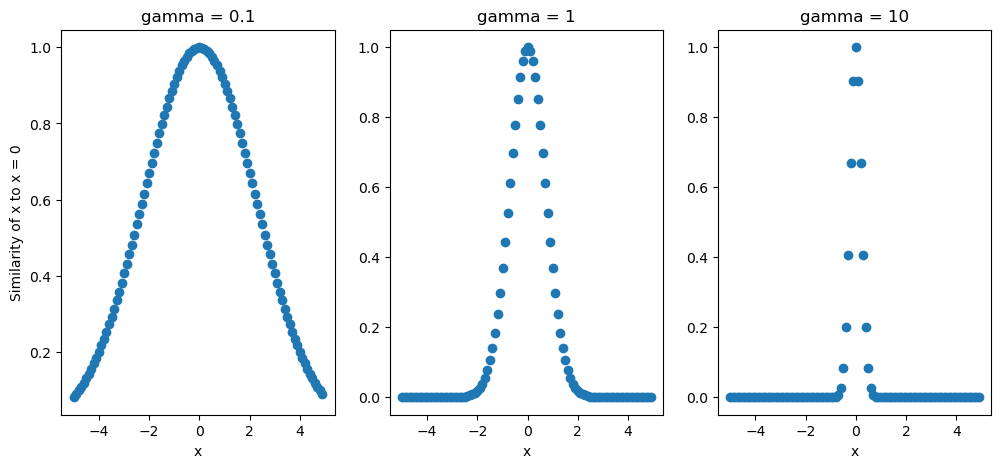

In [2]:
x = np.arange(-5, 5, .1)

def rbf(midpoint, x, gamma):
    return np.exp(-gamma*(midpoint-x)**2)


fig,ax = plt.subplots(1,3, figsize = (12,5))
ax[0].scatter(x, rbf(0,x,gamma = 0.1))
ax[0].set_title('gamma = 0.1')
ax[1].scatter(x, rbf(0,x,gamma = 1))
ax[1].set_title('gamma = 1')
ax[2].scatter(x, rbf(0,x, gamma = 10))
ax[2].set_title('gamma = 10')

for i in range(3):
    ax[i].set_xlabel('x')
    
ax[0].set_ylabel('Similarity of x to x = 0')

## To calculate explained variance:

In [11]:
import numpy as np
import pandas as pd

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler 
from sklearn.decomposition import PCA, KernelPCA

from subductionPCA.FigureMaker import FigureMaker


class LogTransformer(TransformerMixin, BaseEstimator):
    """
    A transformer that applies natural logarithm transformation to the input data.

    Attributes:
    -----------
    seed : float
        The seed value used for adding to the input data before logarithmic transformation.
    """

    def __init__(self):
        """
        Initialize the LogTransformer.

        Parameters:
        -----------
        seed : float, optional, default: 1e-5
            A small value added to the input data before applying logarithm to avoid taking the logarithm of zero or negative values.
        """
        self.seed = 1e-5

        
    def fit(self, X):
        """
        Fit the LogTransformer to the data. This method does nothing as this transformer does not learn anything from the data.

        Parameters:
        -----------
        X : array-like or sparse matrix, shape (n_samples, n_features)
            The input data.

        Returns:
        --------
        self : object
            Returns the instance itself.
        """
        return self

    
    def transform(self, X, y=None):
        """
        Transform the input data by applying natural logarithm.

        Parameters:
        -----------
        X : array-like or sparse matrix, shape (n_samples, n_features)
            The input data.

        Returns:
        --------
        X_transformed : array-like or sparse matrix, shape (n_samples, n_features)
            The transformed data after applying natural logarithm to each element.
        """
        return np.log(X + self.seed)


In [12]:
# adapted to retain all PCs (needed to calculate the variance explained for the RBF kernel)

class Projector():

    def __init__(self, params, threshold, features=['Sed_Thick', 'Dip', 'Vel', 'Rough'], generate_figures=False):
        """
        Initialize the Projector.

        Parameters:
        -----------
        params : dict
            Dictionary containing parameters for scaler (scaler type) and PCA (kernel type, or no kernel (None)).

        features : list, optional, default: ['Sed_Thick', 'Age', 'Dip', 'Vel', 'Rough']
            List of feature names.

        generate_figures : bool, optional, default: False
            Whether to generate figures after projection.
        """
        self.features = features
        self.n_components = len(self.features)
        self.threshold = threshold
        self.all_features = ['Sed_Thick', 'Age', 'Dip', 'Vel', 'Rough']

        # data loading and preprocessing
        self.data = self.load_data()

        # projector parameters
        self.params = params
        self.scaler = self.get_scaler()
        self.pca = self.define_pca()

        # PCA projections
        self.projector = self.get_projector()
        self.n_pcs, self.data_projected = self.project(self.data)
        
        # calculate explained variance
        self.cumulative_explained_variance_ratio = self.calculate_variance_explained() 

        # generate figures
        if generate_figures:
            FigureMaker(projector = self)
            
        # for linear PCA: display components    
        if self.params['kernel'] is None:
            W = pd.DataFrame(self.pca.components_.T, index=self.features, columns=[f'PC{i}' for i in range(1, len(self.features)+1)])
            display(W)
            
    def load_data(self, path='data/preprocessed_data_ghea.csv'):
        """
        Load the data and drop unnecessary columns.

        Parameters:
        -----------
        path : str, optional, default: 'data/preprocessed_data.csv'
            File path to the preprocessed data.

        Returns:
        --------
        all_data : DataFrame
            Loaded and preprocessed subduction margin property dada.
        """
        
        all_data = pd.read_csv(path).drop(columns=['Unnamed: 0', 'Segment', 'sSSE', 'lSSE'])
        return all_data

    
    def get_projector(self):
        """
        Create and return the projector object.

        Returns:
        --------
        pca_projector : object
            Projector object (containing data preprocessing and (Kernel)-PCA projection).
        """
        to_log = [ft for ft in self.features if ft in ['Sed_Thick', 'Dip', 'Rough']]

        log_preproc = Pipeline([('Imputer', SimpleImputer(strategy='mean')),
                                ('Log Transform', LogTransformer()),
                                ('Scaler', self.scaler)])

        no_log_preproc = Pipeline([('Imputer', SimpleImputer(strategy='mean')),
                                    ('Scaler', self.scaler)])

        pca_preproc = ColumnTransformer([
            ('Log. Preprocessor', log_preproc, to_log),
            ('Preprocessor', no_log_preproc, [ft for ft in self.features if ft not in to_log])],
            remainder='drop')

        pca_pipe = Pipeline([
            ('preprocessing', pca_preproc),
            ('PCA', self.pca)])

        feature_preproc = ColumnTransformer([
            ('Imputer', SimpleImputer(strategy='mean'), self.all_features)],
            remainder='passthrough')

        pca_projector = FeatureUnion([('Feature processing', feature_preproc),
                                      ('PCA projection', pca_pipe)])

        pca_projector.fit(self.data)

        return pca_projector

    
    def project(self, X):
        """
        PCA-project the data.

        Parameters:
        -----------
        X : DataFrame
            Input data (margin property data).

        Returns:
        --------
        n_pcs: int
            number of calculated prinicpal components
        X_projected : DataFrame
            PCA-projected data.
        """
        X_projected = self.projector.transform(X)
        
        n_pcs = X_projected.shape[1] - 9 # 9 other columns; the rest are principal components 
        new_columns = self.all_features + [col for col in X.columns if col not in self.all_features] + \
                [f'PC{i}' for i in range(1, n_pcs+1)]
        
        X_projected = pd.DataFrame(X_projected, columns=new_columns)

        return n_pcs, X_projected
    
    
    def calculate_variance_explained(self):
        '''
        Calculate the cululative explained variance ratio for the PCs. 
        
        Returns:
        --------
        - cumulative_explained_variance_ratio: array containing cumulative explained variance ratio for each PC
        '''
        X_proj_pca = self.data_projected[[f'PC{i}' for i in range(1, self.n_pcs+1)]]
        explained_variance_ratio = (X_proj_pca.std()**2 / ((X_proj_pca.std()**2).sum())).values
        cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
        
        return cumulative_explained_variance_ratio

    
    def get_scaler(self):
        """
        Get the scaler object based on input parameters.

        Returns:
        --------
        scaler : object
            Scaler object.
        """
        if self.params['scaler'] == 'StandardScaler':
            scaler = StandardScaler()
        elif self.params['scaler'] == 'RobustScaler':
            scaler = RobustScaler()
        elif self.params['scaler'] == 'MinMaxScaler':
            scaler = MinMaxScaler()
        else:
            raise ValueError('Scaler input not valid')

        return scaler

    
    def define_pca(self):
        """
        Define the PCA object based on input parameters.

        Returns:
        --------
        pca : object
            PCA object.
        """
        if self.params['kernel'] is None:
            pca = PCA(n_components=self.n_components, random_state=42)
        else:
            pca = KernelPCA(kernel=self.params['kernel'], gamma = self.params['gamma'], random_state=42)

        return pca

    


In [13]:
projector = Projector(params=params, features=features, threshold = 8)
projector.cumulative_explained_variance_ratio

,PC1,PC2,PC3,PC4
Sed_Thick,-0.504571,0.523207,-0.238759,-0.643939
Dip,0.584341,-0.137760,0.372235,-0.707820
Vel,0.316793,0.827624,0.361085,0.290342
Rough,0.550996,0.149381,-0.821007,-0.005957


array([0.4783089495631194, 0.7300983086789345, 0.8772144531478785, 1.0],
      dtype=object)